In [1]:
# set up environment
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sb
import time

In [2]:
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\gonorrhoea'

In [24]:

df = pd.read_csv(dirpath+'/cip_sr_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
df

,ERR1549286,ERR1549290,ERR1549291,ERR1549287,ERR1549288,ERR1549299,ERR1549292,ERR1549298,ERR1549296,ERR1549300,...,ERR2172345,ERR2172346,ERR2172347,ERR2172348,ERR2172349,ERR2172350,ERR2172351,ERR2172352,ERR2172353,ERR2172354
pattern_id,,,,,,,,,,,,,,,,,,,,,
ACGTTTATGCCGTTATCGATCCGATAGCCGGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
CATCTGCACCCTGTCGGCACTCGCCGCCTGAACCACCCCGTCCGGACAAGG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"CACAAAACTCGTTTCCTGCTCCGAAATGGGCGA,GTAAGGGCTTTCTTAAATTTGATTAAAGGTCGTCTGAA,AACCGAAACCGACCGCGCCGTCGAATATCAGGCGGTCGCACCGGAAGTACG",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAATCTTCCGCTTTAATCCATTTGCCGTCCGA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"AAACCTGCCGCAGCCGGCGCATCTTTGGGCGGCGGTCTGGAC,AACGTGGTGTACCAAACCCGCCGTTTCGACCGTTATAAAGAA",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAGCAGCGCACGCTGTGAATCACATCTTTCGCC,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ACCGCGCCGGACAGGGTGCGCGTAAACGGCAGTTG,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
AACGACAATACACACACCCTTCCCCCGCGCC,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
# a function for preparing our training and testing data
def prep_data(phenotype) :
    pheno = pd.read_csv(dirpath+'/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]
        
    # read in unitig data
    X = pd.read_csv(dirpath+'/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

In [19]:
X

pattern_id,CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG,TACCGTAACCGGCAATGCGGATATTACGGTC,CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG,AACGGGTTTTCAGACGGCATTCGATATCGGGACG,CCAAAAATTACCCGCGTTGACGTAGCTAAAGA,CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC,TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG,"TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC",GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC,TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC,...,ACCGATGAGTTCGCCGGAATCGGTACGATTGAC,CTGCTGGACAAAAAAGGGATTAAAGATATCACC,CGTTCCTTTCGGCGTATTCTCGCCGTTGCGCGGCG,TCACATTTCCGCTTCAGACGGCATCCGATATGA,GAAGCTGCCACGCCGGCAGAAGTGTTGTTTGCGGG,ACGCCGAAAGGAACGTGTATGCTGCCGCCCAACTGCG,ACTCGAATTTTGCAGGATTGGTATCAATGGCGATAATGCGACCGGCTTTGG,"ACCCGGCCCGGGCTGGCAGGCTACGGCTACACCGGTATCC,CACCTTAGGGAATCGTTCCCTTTGGGCCGGG,TACGCCGAAAGGAACGTGTATGCTGCCGCCC,GGGATTGTTGATTGTCGGACTGTTGTGCAACCTC",AGCCTGATTCACCAATGGTTTGTTCATAACAA,TTTTGAGCAGAAAGCAGTCAAAAACAGGGGGATTTTGCCCTTTTGACAGGTTCGAGTGCCG
ERR1549286,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR1549290,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR1549291,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR1549287,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR1549288,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR2172350,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR2172351,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR2172352,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
ERR2172353,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [4]:
# prepare our data for predicting antibiotic resistance
phenotype = 'azm_sr'
X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = []
method = []
times = []

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


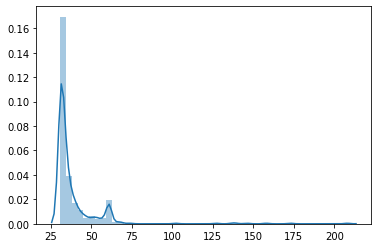

In [5]:
# look at the length distribution of the unitigs in our dataset
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

In [6]:
# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [8]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[525  25]
 [ 26 120]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'l1_ratio': 0.5}
Confusion matrix for this fold
[[646   3]
 [ 12  35]]
Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[602  23]
 [ 26  44]]
Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[504  15]
 [ 20 156]]


In [9]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


In [10]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[534  16]
 [ 15 131]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[685   3]
 [  0   8]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[590  35]
 [  9  61]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.

In [11]:


rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)



Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

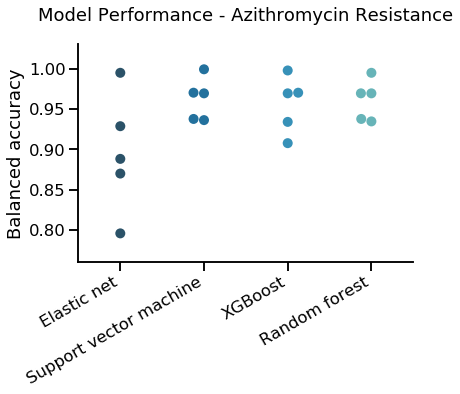

In [12]:
# compare results from the different predictors
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

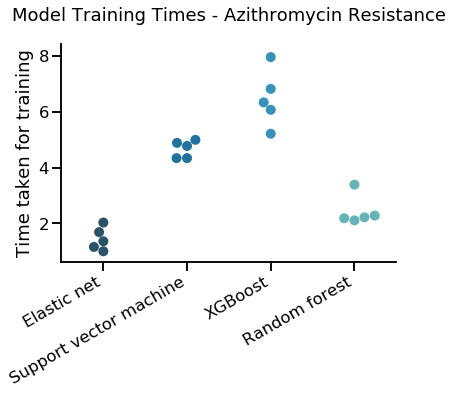

In [13]:
# took at the time taken to train the different models
sb.set_context("talk")
plt.title("Model Training Times - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

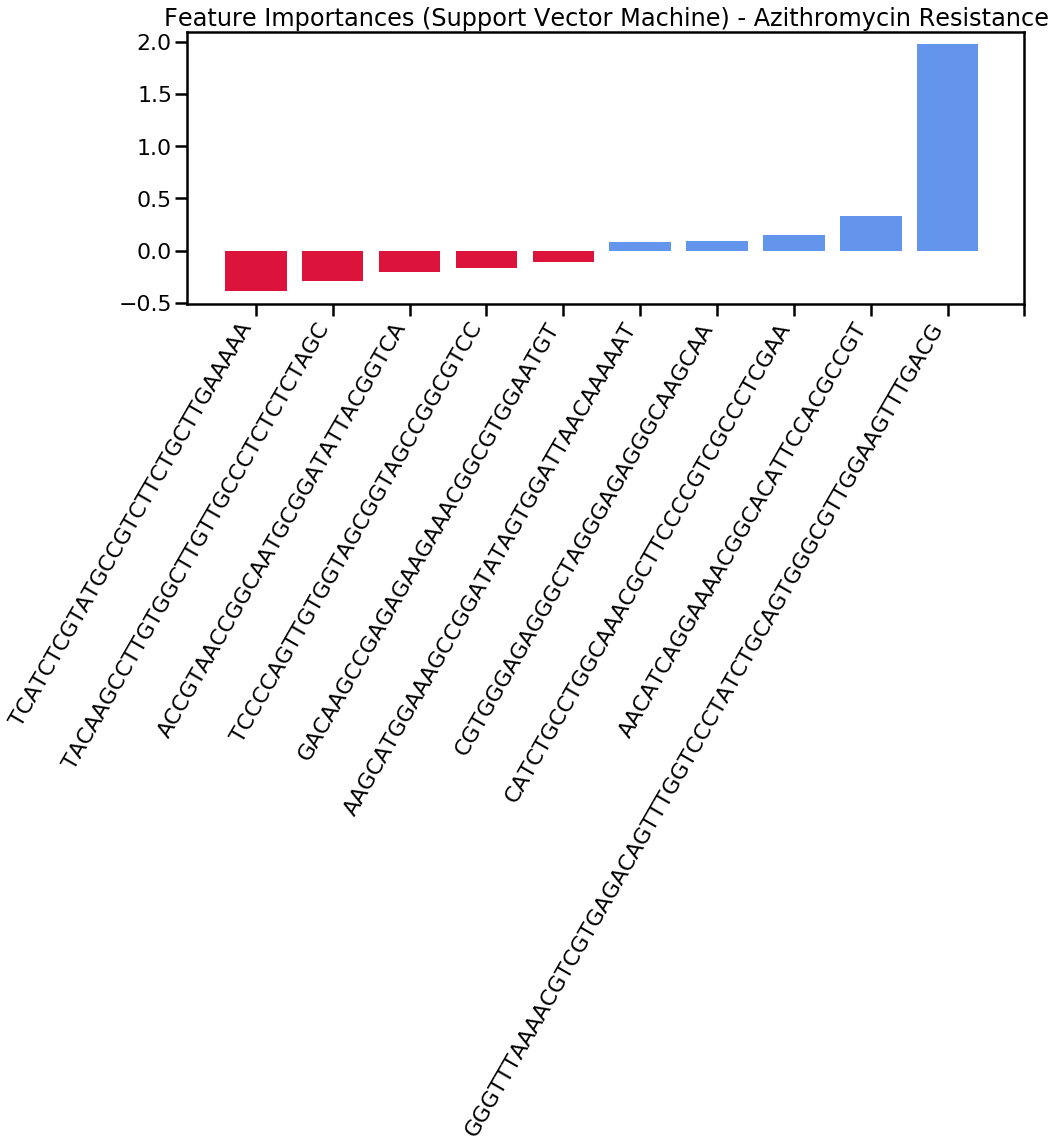

In [14]:
# function for looking at SVM feature importance
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    sb.set_context("poster")
    plt.figure(figsize=(15, 5))
    plt.title("Feature Importances (Support Vector Machine) - Azithromycin Resistance")
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))
    
# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

Top negative predictors:  ['TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'TACAAGCCTTGTGGCTTGTTGCCCTCTCTCTAGC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'TCCCCAGTTGTGGTAGCGGTAGCCGGCGTCC'
 'GACAAGCCGAGAGAAGAAACGGCGTGGAATGT']
Top positive predictors:  ['AAGCATGGAAAGCCGGATATAGTGGATTAACAAAAAT' 'CGTGGGAGAGGGCTAGGGAGAGGGCAAGCAA'
 'CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG']


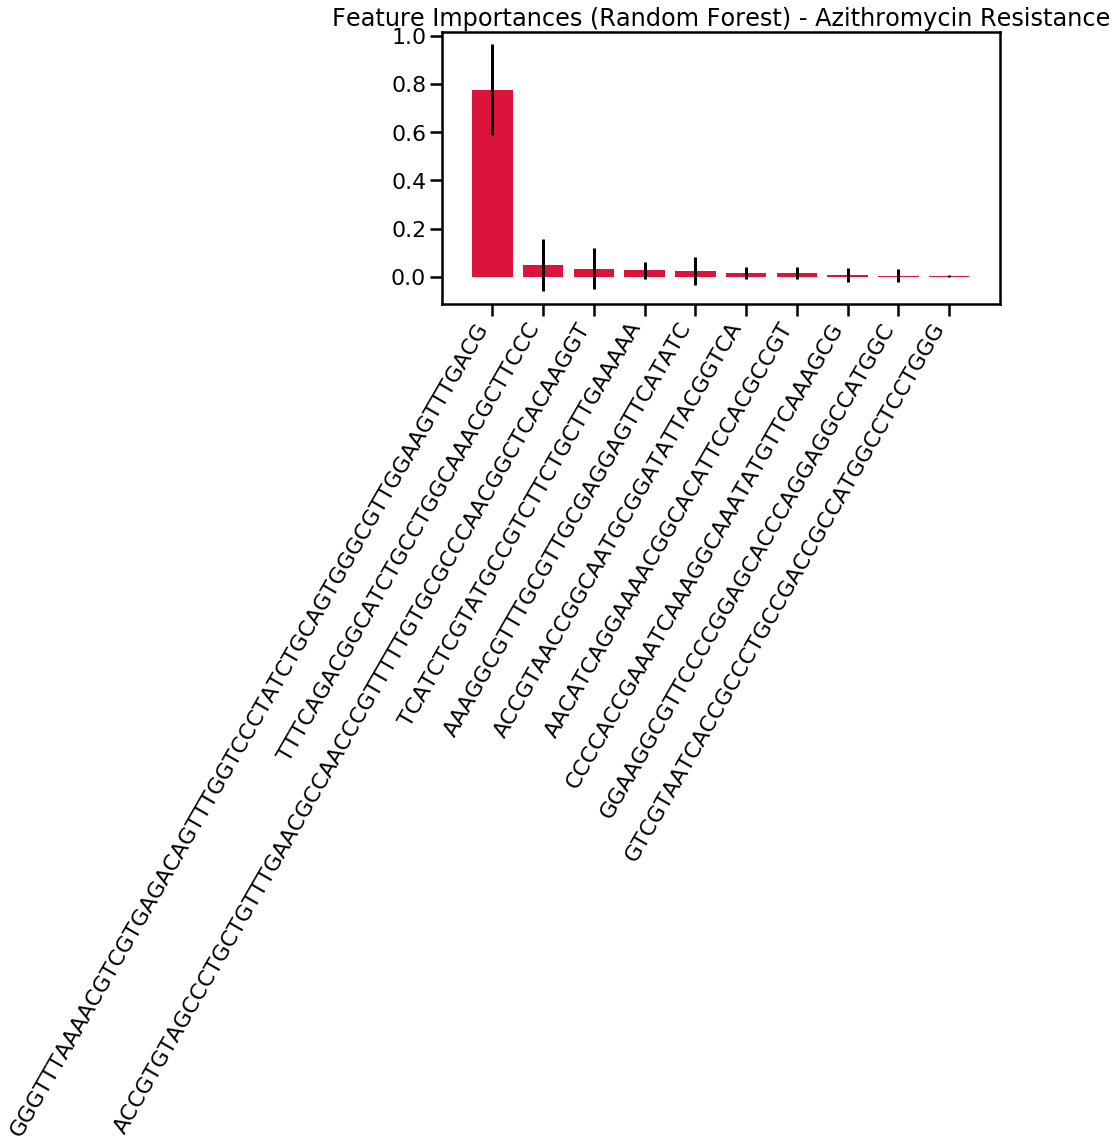

Top predictors:  ['GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG'
 'TTTCAGACGGCATCTGCCTGGCAAACGCTTCCC'
 'ACCGTGTAGCCCTGCTGTTTGAACGCCAACCCGTTTTTGTGCGCCCAACGGCTCACAAGGT'
 'TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'AAAGGCGTTTGCGTTGCGAGGAGTTCATATC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'CCCCACCGAAATCAAAGGCAAATATGTTCAAAGCG'
 'GGAAGGCGTTCCCCGGAGCACCCAGGAGGCCATGGC'
 'GTCGTAATCACCGCCCTGCCGACCGCCATGGCCTCCTGGG']


In [15]:


importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Plot the feature importances of the forest
sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Azithromycin Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])



In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    sb.set_context("talk")
    plt.figure(figsize=(7, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Balanced accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="balanced_accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='gainsboro')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="crimson")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="cornflowerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="cornflowerblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

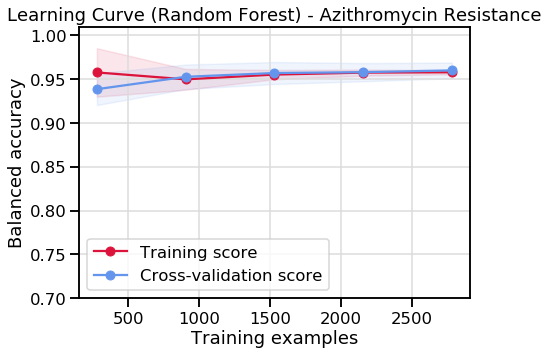

In [17]:
title = "Learning Curve (Random Forest) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features=round(X.shape[1]*0.5), n_jobs=-1, max_depth=3, n_estimators=50)
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

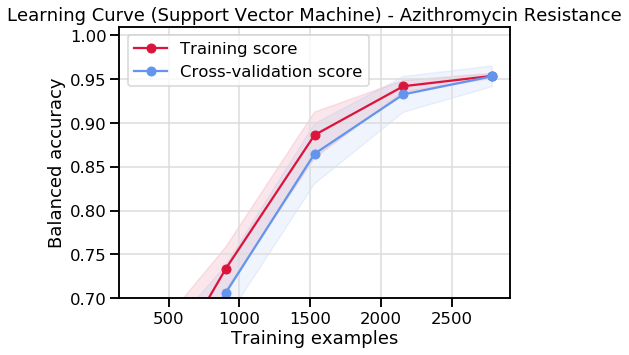

In [18]:
title = "Learning Curve (Support Vector Machine) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C=0.01, gamma=1e-06, kernel='linear')
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()